In [ ]:
pip install networkx

In [ ]:
pip install pycountry

In [ ]:
pip install plotly

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import networkx as nx
from networkx.algorithms import bipartite
import pycountry
import itertools

## Loading the dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Network/fts.xlsx')

In [ ]:
df.head()

## Preprocessing the dataset

In [ ]:
# Converting 'amountUSD' column to numeric (if not already numeric)
df['amountUSD'] = pd.to_numeric(df['amountUSD'], errors='coerce')

In [ ]:
# Dropping the rows with NaN values in 'amountUSD' column
df = df.dropna(subset=['amountUSD'])

In [ ]:
# Exporting the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/Network/entire_dataframe.csv', index=False)

print("CSV file has been exported successfully.")

In [ ]:
# Converting 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extracting year from 'date' column
df['year'] = df['date'].dt.year

In [ ]:
# Defining a helper function to get country name from ISO-3 code
def get_country_name(iso_code):
    try:
        return pycountry.countries.get(alpha_3=iso_code).name
    except AttributeError:
        return None

# Defining helper function to check if a code is a valid ISO-3 code
def is_valid_iso_code(code):
    if not isinstance(code, str):
        return False
    try:
        return pycountry.countries.get(alpha_2=code) is not None or pycountry.countries.get(alpha_3=code) is not None
    except LookupError:
        return False

## Visualizing network(s)

### Cleaned network

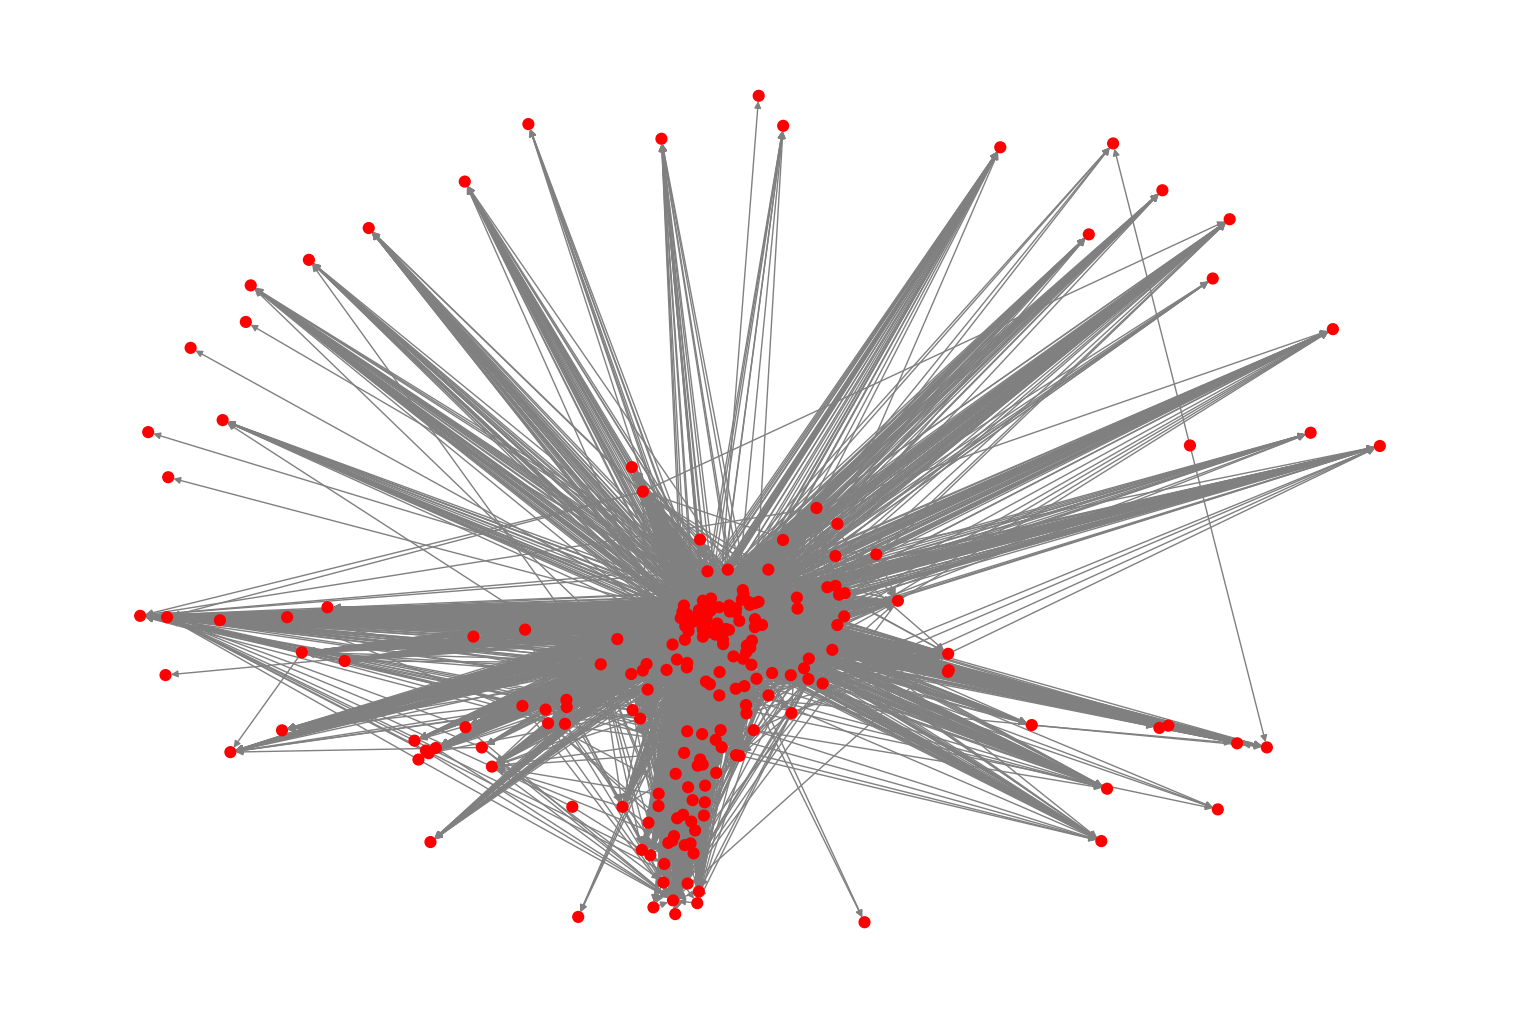

In [ ]:
# Identifying nodes that should be painted red
nodes_to_paint_red = set(df['country_iso3'])
nodes_to_paint_red.update(node for node in df['Organization'] if is_valid_iso_code(node))


# Filtering out non-country organizations
df['country_name'] = df['country_iso3'].apply(get_country_name)
df = df[df['country_name'].notnull()]

# Filtering out non-country organizations for donors and recipients
df = df[df['Organization'].apply(is_valid_iso_code) & df['country_iso3'].apply(is_valid_iso_code)]

# Summing edges between the same vertices
df_summed = df.groupby(['year', 'Organization', 'country_iso3']).agg({'amountUSD': 'sum'}).reset_index()

# Creating the graph
G = nx.from_pandas_edgelist(df_summed, source='Organization', target='country_iso3', edge_attr='amountUSD', create_using=nx.DiGraph())

# Removing self-loops
G.remove_edges_from(nx.selfloop_edges(G))


# Drawing the graph
plt.figure(figsize=(15, 10))
node_colors = ['red' if node in nodes_to_paint_red else 'skyblue' if node not in nodes_to_paint_blue else 'white' for node in G.nodes()]
nx.draw(G, with_labels=False, node_size=60, node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')

### Spring layout network

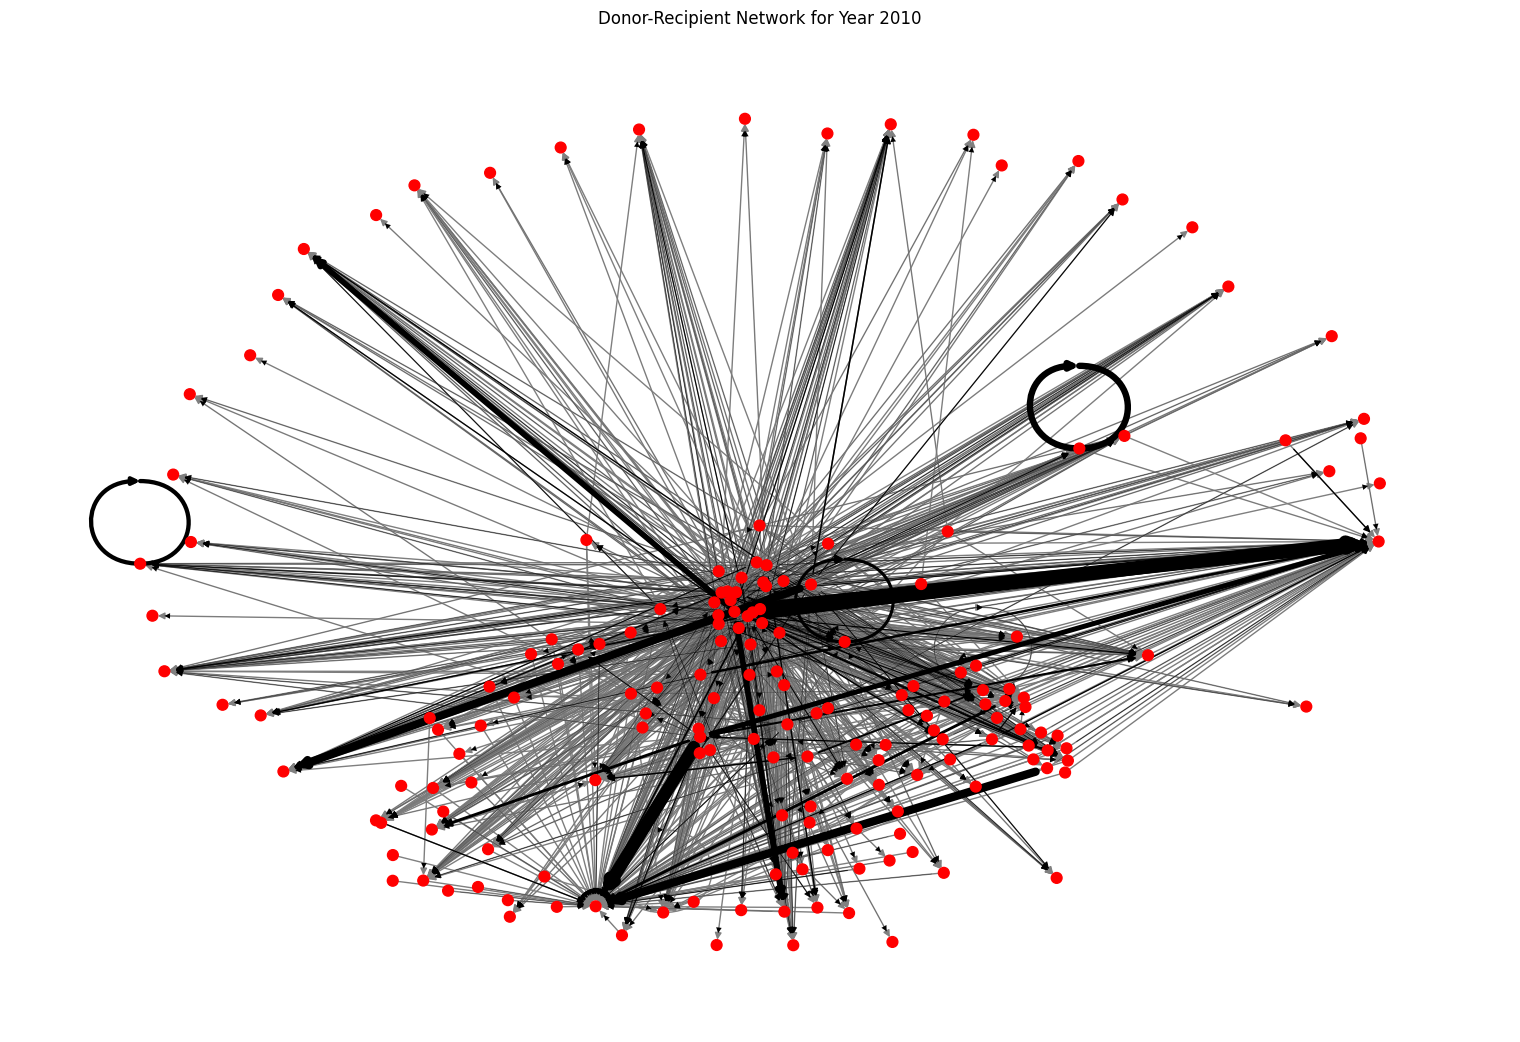

In [ ]:
# Creating the graph
G = nx.from_pandas_edgelist(df_year, source='Organization', target='country_iso3', edge_attr='amountUSD', create_using=nx.DiGraph())
pos = nx.spring_layout(G, k=0.5, iterations=100)

# Identifying nodes that should be painted red
nodes_to_paint_red = set(df_year['country_iso3'])
nodes_to_paint_red.update(node for node in df_year['Organization'] if is_valid_iso_code(node))

# Drawing the graph
plt.figure(figsize=(15, 10))
node_colors = ['red' if node in nodes_to_paint_red else 'skyblue' for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=60, node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')

# Scaling the edge weights
weights = [G[u][v]['amountUSD'] for u, v in G.edges()]
max_weight = max(weights)
scaled_weights = [weight / max_weight * 10 for weight in weights]
nx.draw_networkx_edges(G, pos, width=scaled_weights, edge_color='black')

plt.title(f'Donor-Recipient Network for Year {year_filter}')
plt.show()

### Sankey diagram

In [ ]:
# Defining a function to create a Sankey diagram for a specific year
def create_sankey(df_year):
    df_sankey = df_year.groupby(['Source', 'Target'])['Value'].sum().reset_index()

    all_nodes = list(pd.concat([df_sankey['Source'], df_sankey['Target']]).unique())
    mapping = {node: i for i, node in enumerate(all_nodes)}
    df_sankey['Source'] = df_sankey['Source'].map(mapping)
    df_sankey['Target'] = df_sankey['Target'].map(mapping)

    link = dict(source=df_sankey['Source'].tolist(), target=df_sankey['Target'].tolist(), value=df_sankey['Value'].tolist())
    node = dict(label=all_nodes, pad=15, thickness=20, line=dict(color="black", width=0.5))
    return link, node

# Filtering the dataframe for the selected year
selected_year = 2010
df_year = df[df['year'] == selected_year]

# Creating the Sankey diagram for the selected year
link, node = create_sankey(df_year)
data = go.Sankey(link=link, node=node)

# Creating the layout for the Sankey diagram
layout = go.Layout(
    title= f'Sankey Diagram for Donor-Recipient Network for Year {selected_year}',
    width=2000,
    height=2500,
    font=dict(size=10)
)

# Combining data and layout into a Figure object
fig = go.Figure(data=data, layout=layout)


fig.show()

## Analyses

### Local clustering coefficients

In [ ]:
# Initializing a dictionary to store clustering coefficients data
clustering_data = {}

# Creating a directed graph from the filtered dataframe
G_year = nx.DiGraph()
for _, row in df.iterrows():
    G_year.add_edge(row['Organization'], row['country_iso3'], weight=row['amountUSD'])

# Iterating through each year
for year in df['year'].unique():
    # Initializing a dictionary to store clustering coefficients for the current year
    clustering_data[year] = {}

    # Filtering dataframe for the current year
    yearly_df = df[df['year'] == year]

    # Calculating the clustering coefficient for each country (designated by ISO-3 codes)
    for country in yearly_df['country_iso3'].unique():
        country_name = get_country_name(country)

        if country_name not in clustering_data[year]:
            clustering_data[year][country_name] = {}

        # Calculating the local clustering coefficient for outgoing edges
        out_edges = G_year.out_edges(country)
        neighbors = set([target for _, target in out_edges])
        if len(neighbors) < 2:
            clustering_coef = 0.0
        else:
            possible_triangles = 0
            actual_triangles = 0
            for neighbor in neighbors:
                neighbor_out_edges = G_year.out_edges(neighbor)
                neighbor_neighbors = set([target for _, target in neighbor_out_edges])
                common_neighbors = neighbors.intersection(neighbor_neighbors)
                possible_triangles += len(neighbors) - 1
                actual_triangles += len(common_neighbors)
            if possible_triangles == 0:
                clustering_coef = 0.0
            else:
                clustering_coef = actual_triangles / possible_triangles

        clustering_data[year][country_name] = clustering_coef

# Converting the dictionary to a DataFrame
clustering_df = pd.DataFrame.from_dict({(i, j): clustering_data[i][j]
                                         for i in clustering_data.keys()
                                         for j in clustering_data[i].keys()},
                                        orient='index')

# Filling NaN values with 0
clustering_df = clustering_df.fillna(0)

Shapiro-Wilk test results for each year:
          W       p-value
0  0.866156  4.203895e-45


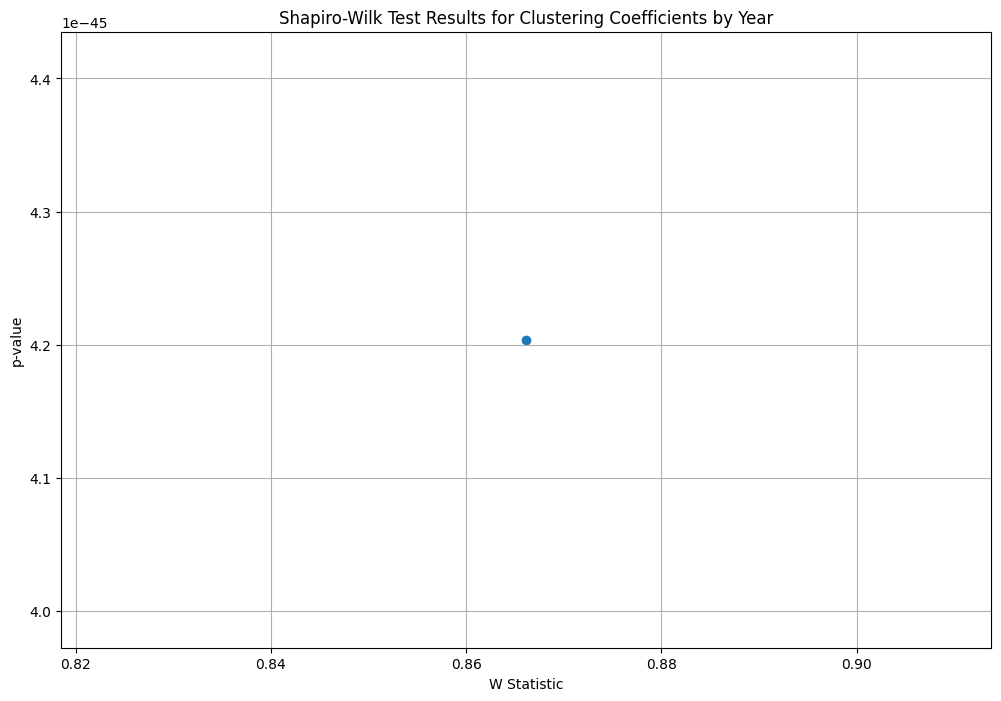

Reject the null hypothesis of normality.


In [ ]:
from scipy.stats import shapiro, norm

# Performing Shapiro-Wilk test for each year
shapiro_results = {}

for year in clustering_df.columns:
    coef_values = clustering_df[year].values
    if len(coef_values) > 2:  # Shapiro-Wilk test requires at least 3 values
        stat, p_value = shapiro(coef_values)
        shapiro_results[year] = {'W': stat, 'p-value': p_value}

# Converting the Shapiro-Wilk results to a DataFrame
shapiro_df = pd.DataFrame.from_dict(shapiro_results, orient='index')

print("Shapiro-Wilk test results for each year:")
print(shapiro_df)

# Plotting the Shapiro-Wilk test results
plt.figure(figsize=(12, 8))
plt.scatter(shapiro_df['W'], shapiro_df['p-value'])
plt.xlabel('W Statistic')
plt.ylabel('p-value')
plt.title('Shapiro-Wilk Test Results for Clustering Coefficients by Year')
plt.grid(True)
plt.show()

# Assuming clustering_coef_data is a list or array containing your clustering coefficient values
W_statistic, p_value = shapiro(clustering_df)

# Calculating critical value based on sample size (n)
n = len(clustering_df)

alpha = 0.05

# For small sample sizes, we can consult specialized tables or use specific functions to get the critical value
# For larger sample sizes, we can approximate using a normal distribution
if n <= 50:
    # We can use specialized tables or functions to get the critical value
    # For example, for n=20 and alpha=0.05, we might find the critical value to be approximately 0.892
    critical_value = get_critical_value_from_table(n, alpha)
else:
    # Approximate the critical value using a normal distribution
    critical_value = norm.ppf(1 - alpha/2)  # Use the 2-tailed critical value for alpha/2

# Comparing the computed W statistic with the critical value
if W_statistic < critical_value:
    print("Reject the null hypothesis of normality.")
else:
    print("Fail to reject the null hypothesis of normality.")

In [ ]:
# Extracting W-statistics from Shapiro-Wilk test results
W_statistics = [result['W'] for year, result in shapiro_results.items()]

# Calculating the average of W-statistics
average_W_statistic = sum(W_statistics) / len(W_statistics)

print("Average W-statistic:", average_W_statistic)

Average W-statistic: 0.8661559820175171


###Edge weight distributions


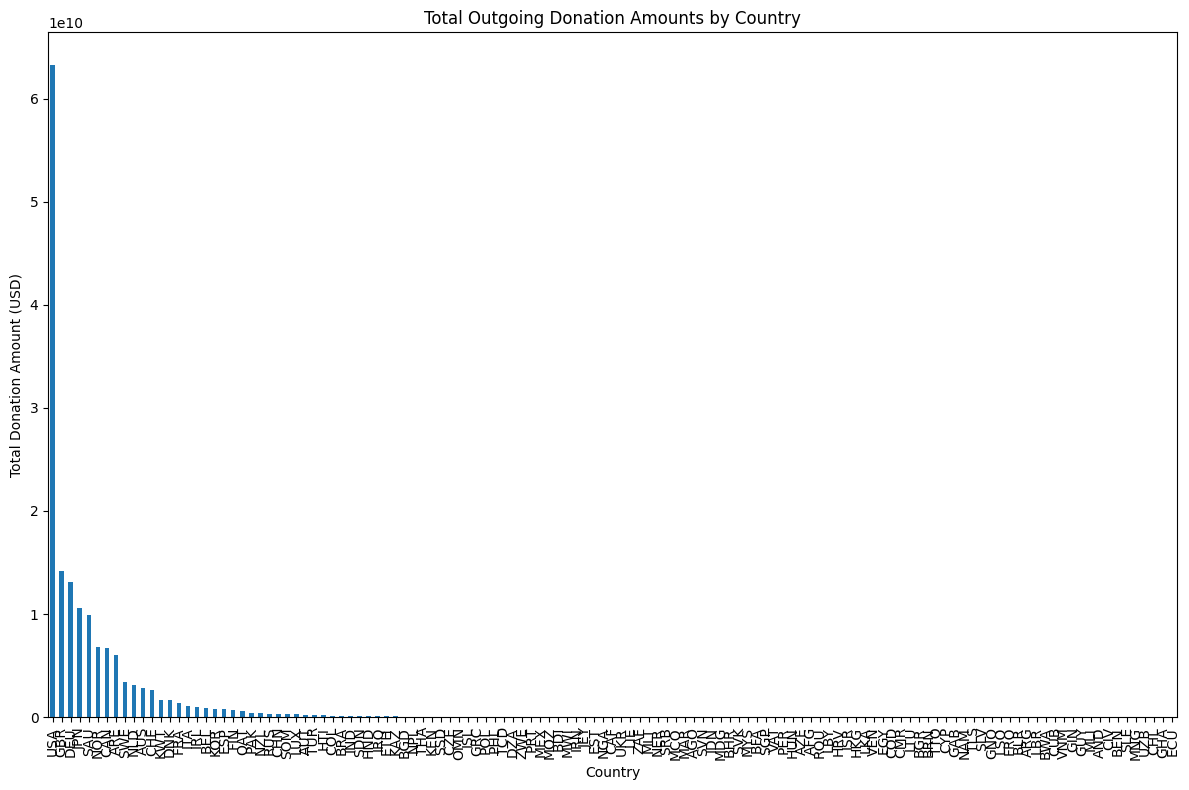

In [ ]:
# Summing the outgoing donations for each country
total_donations = df[df['status'] == 'paid'].groupby('Organization')['amountUSD'].sum()

# Filtering out countries with zero donations
total_donations = total_donations[total_donations > 1000000]

# Sorting the donations in descending order
total_donations = total_donations.sort_values(ascending=False)

# Plotting the bar chart
plt.figure(figsize=(12, 8))
total_donations.plot(kind='bar')
plt.title('Total Outgoing Donation Amounts by Country')
plt.xlabel('Country')
plt.ylabel('Total Donation Amount (USD)')
plt.xticks(rotation=90)
plt.tight_layout()


plt.show()

In [ ]:
# Summing the total outgoing donations for all countries
total_donations_all_countries = df[df['status'] == 'paid']['amountUSD'].sum()

# Summing the total outgoing donations for USA
total_donations_usa = df[(df['status'] == 'paid') & (df['Organization'] == 'USA')]['amountUSD'].sum()

# Calculating the percentage of total aid provided by USA
percentage_usa_donations = (total_donations_usa / total_donations_all_countries) * 100

# Displaying the results
print(f"Total aid provided by USA: ${total_donations_usa:,.2f}")
print(f"Percentage of total aid provided by USA: {percentage_usa_donations:.2f}%")


Total aid provided by USA: $63,258,364,276.00
Percentage of total aid provided by USA: 40.02%


In [ ]:
# Summing the outgoing donations for each donor
total_donations_per_donor = df.groupby('Organization')['amountUSD'].sum()

# Identifying the top 10 donors by the total amount of donations
top_10_donors = total_donations_per_donor.nlargest(10)

# Calculating the total amount of aid provided by the top 10 donors
total_aid_top_10_donors = top_10_donors.sum()

# Calculating the overall total aid
overall_total_aid = total_donations_per_donor.sum()

# Calculating the percentage of the total aid provided by the top 10 donors
percentage_aid_top_10_donors = (total_aid_top_10_donors / overall_total_aid) * 100


print(f"Total aid provided by the top 10 donors: ${total_aid_top_10_donors:,.2f}")
print(f"Percentage of total aid provided by the top 10 donors: {percentage_aid_top_10_donors:.2f}%")

Total aid provided by the top 10 donors: $236,962,272,258.67
Percentage of total aid provided by the top 10 donors: 85.97%


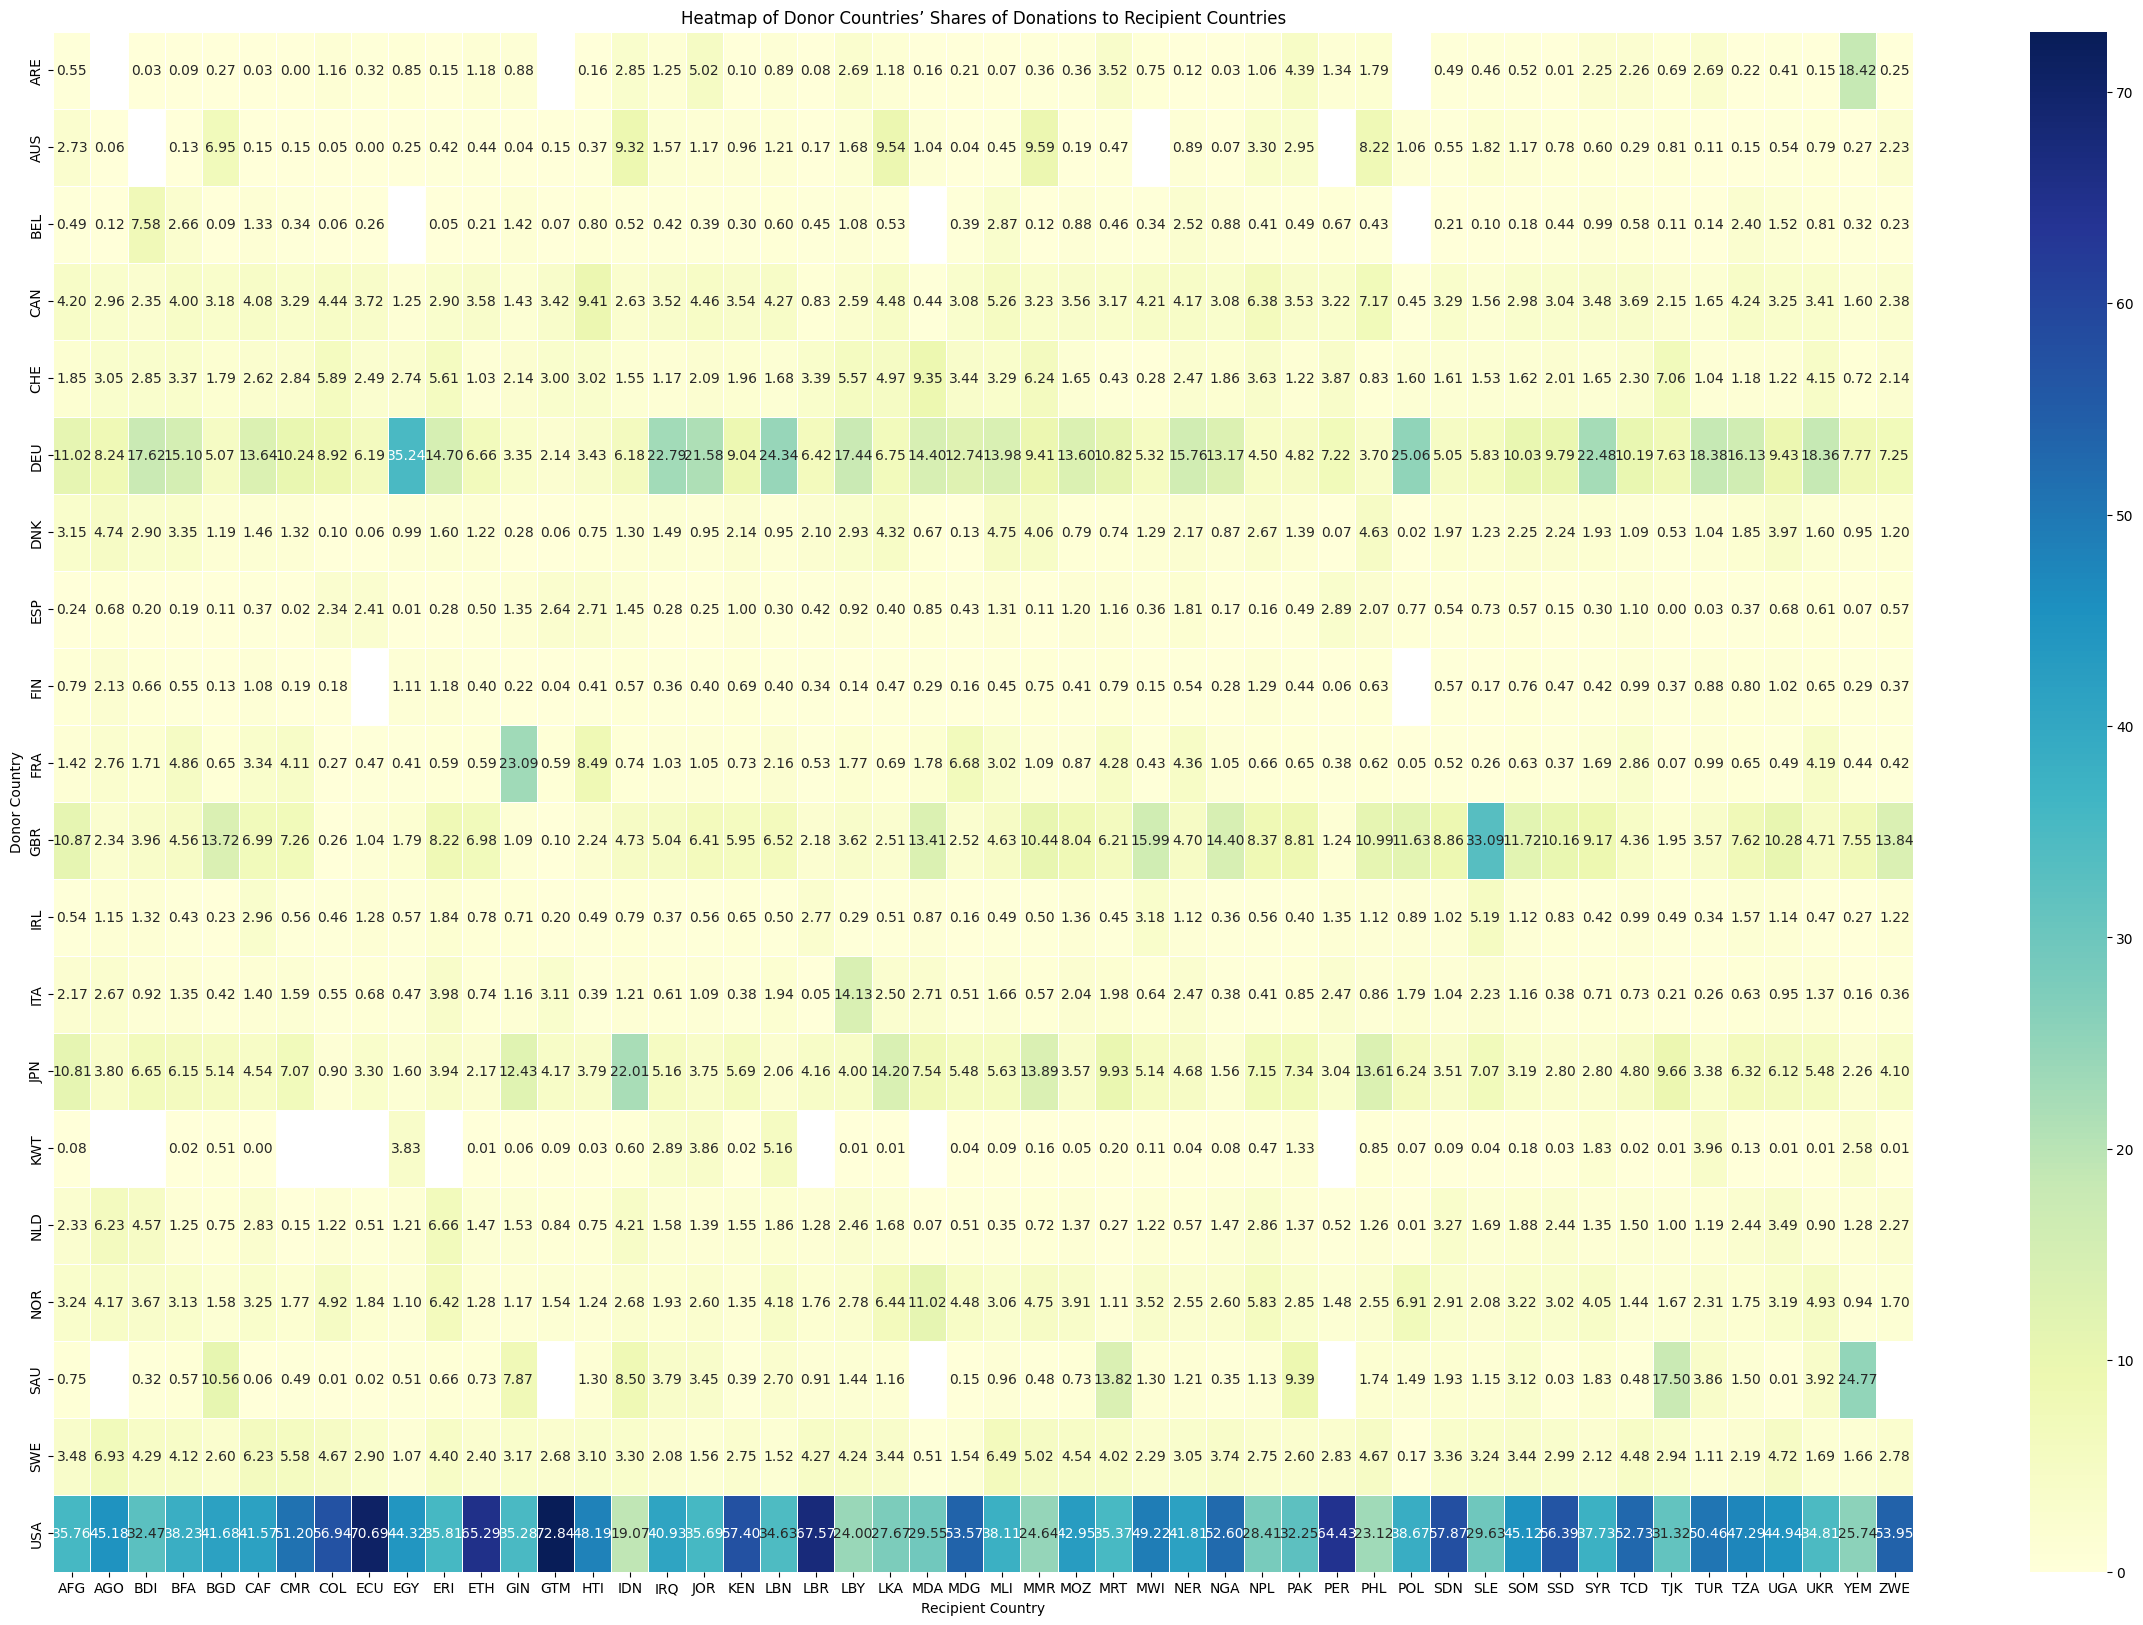

In [ ]:
import seaborn as sns
# Grouping by donor and recipient countries and sum the donation amounts
donor_recipient_sums = df.groupby(['Organization', 'country_iso3'])['amountUSD'].sum().reset_index()

# Calculating the total donations per recipient country
total_donations_per_recipient = donor_recipient_sums.groupby('country_iso3')['amountUSD'].sum().reset_index()
total_donations_per_recipient.columns = ['country_iso3', 'total_donations']

# Getting the top 50 recipients
top_recipients = total_donations_per_recipient.nlargest(50, 'total_donations')['country_iso3']

# Filtering the donor_recipient_sums to include only the top 50 recipients
filtered_donor_recipient = donor_recipient_sums[donor_recipient_sums['country_iso3'].isin(top_recipients)]

# Calculating the total donations per donor country
total_donations_per_donor = donor_recipient_sums.groupby('Organization')['amountUSD'].sum().reset_index()
total_donations_per_donor.columns = ['Organization', 'total_donations']

# Getting the top 20 donors
top_donors = total_donations_per_donor.nlargest(20, 'total_donations')['Organization']

# Filtering the donor_recipient_sums to include only the top 20 donors
filtered_donor_recipient = filtered_donor_recipient[filtered_donor_recipient['Organization'].isin(top_donors)]

# Merging the total donations per recipient with the filtered donor_recipient_sums
merged_df = pd.merge(filtered_donor_recipient, total_donations_per_recipient, on='country_iso3')

# Calculating the percentage share of donations each donor country contributes to each recipient country
merged_df['percentage'] = (merged_df['amountUSD'] / merged_df['total_donations']) * 100

# Pivoting the data to create the matrix
pivot_df = merged_df.pivot(index='Organization', columns='country_iso3', values='percentage')

# Creating the heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Donor Countries’ Shares of Donations to Recipient Countries')
plt.xlabel('Recipient Country')
plt.ylabel('Donor Country')
plt.show()


### PageRank centrality

In [ ]:
# Filtering the DataFrame to include only donor countries
donor_countries = df['Organization'].unique()

# Creating a directed graph
G = nx.DiGraph()

# Addding edges representing donations from donors to recipient countries
for _, row in df.iterrows():
    if row['Organization'] in donor_countries:
        G.add_edge(row['Organization'], row['country_iso3'], weight=row['amountUSD'])

# Calculating the PageRank centrality for each donor country (based on outgoing edges)
pagerank_donor = nx.pagerank(G, weight='weight')

# Creating a reverse directed graph for incoming edges from neighbors
G_reverse = G.reverse()

# Initializing a dictionary to store the PageRank centrality of neighbor countries
pagerank_neighbors = {neighbor: 0.0 for neighbor in G_reverse.nodes}

# Calculating the PageRank centrality for each neighbor country (based on incoming edges)
for neighbor in G_reverse.nodes:
    pagerank_neighbors[neighbor] = nx.pagerank(G_reverse, personalization={neighbor: 1}, weight='weight')[neighbor]

# Aggregating the PageRank centrality scores for each donor country
pagerank_donor_aggregated = {donor: 0.0 for donor in donor_countries}
for donor in donor_countries:
    for neighbor, pagerank_score in pagerank_neighbors.items():
        if G.has_edge(donor, neighbor):
            pagerank_donor_aggregated[donor] += pagerank_score

# Converting the dictionary to a DataFrame
pagerank_donor_df = pd.DataFrame.from_dict(pagerank_donor_aggregated, orient='index', columns=['pagerank_centrality'])

# Sorting the DataFrame by PageRank centrality in descending order
pagerank_donor_df = pagerank_donor_df.sort_values(by='pagerank_centrality', ascending=False)

print(pagerank_donor_df)

     pagerank_centrality
USA            31.646838
JPN            24.353718
DEU            24.198639
CHE            23.639318
CAN            23.553451
..                   ...
DMA             0.155580
KNA             0.155562
TUV             0.155413
FJI             0.154384
PLW             0.153967

[195 rows x 1 columns]


<Figure size 1000x600 with 0 Axes>

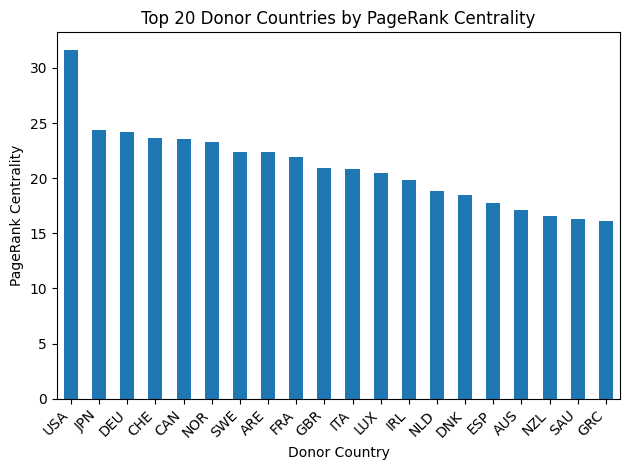

In [ ]:
# Sorting the DataFrame by PageRank centrality in descending order
pagerank_donor_df = pagerank_donor_df.sort_values(by='pagerank_centrality', ascending=False)

# Selecting the top 20 donor countries
top_20 = pagerank_donor_df.head(20)

# Plotting the top 20 donor countries in a bar chart
plt.figure(figsize=(10, 6))
top_20.plot(kind='bar', legend=None)
plt.title('Top 20 Donor Countries by PageRank Centrality')
plt.xlabel('Donor Country')
plt.ylabel('PageRank Centrality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()